# <font color='Orange'>1 - Data Collection and Processing</font>

# <font color='Orange'>1.1 Importing libraries</font>

In [28]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import base64
import requests
import csv
import time
import json
import sys
import imp
import base64
imp.reload(sys)

import matplotlib 
from pylab import *

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('seaborn-darkgrid')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (14, 8) 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

# <font color='Orange'>1.2 Data collection from Spotify API</font>

Below we have written two functions, 1) "EncodeClinentCreds()" which takes 'ClientID' and 'ClientSecert' from the user(it has to be generated by registering to spotify website) and sends the credential to 2) "GetAccessToken()" function where the access_token is generated. This access_token is required to be sent evertime we make a request to the Spotify API to grab the data without which we found the api sends 401 error indicating unauthorized access. 

In [ ]:
#Generating Access Token using clientID and clientSecret
def EncodeClientCreds():
    #Client Id and Clientsecert are generated in spotify api
    clientID = '16383d4706934f01a1e4787307766cc0'
    clientSecret = 'ae816f76f88e4d8bb0610373b692b302'
    creds = clientID + ':' + clientSecret
    return base64.b64encode(creds.encode())

access_token = ""

def GetAccessToken():
    auth = "Basic " + EncodeClientCreds().decode()
    r = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type':'client_credentials'}, headers={'Authorization': auth})
    req_json = r.json()
    access_token = req_json['access_token']
    return "Bearer " + access_token

Below is the function for API_search_request where we find the data such as popularity,song_ids,artist_ids,album_ids.The function API_search_requests has parameter which we use to build the url:
"keywords"    = We pass the year(eg. 1995) for which we are collecting the data. 
search_type   = "track" , indicating we need the track data.
result_limit  = we indicate the limit of the tracks we get (e.g. 50 tracks in every iteration).
result_offset = It is an counter of how many tracks we have added.  

We are also sending,song_id,artist_ids,album_ids and adding to our list track after checking if its already not there in the data. 

In [ ]:
def API_search_request(keywords, search_type, results_limit, results_offset, ltrack, song_ids, artist_ids, album_ids):
    
    access_token = GetAccessToken()
    off = str(results_offset)
    lim = str(results_limit)

    
    #builiding the url using function parameters such as "keywords","search_type","results_limit","results_offset" 
    url = 'https://api.spotify.com/v1/search?q=year:'+ keywords +'&type=' + search_type +'&offset='+ off +'&limit=' + lim
    
    #requesting the for data using the url and also sending the access token for authorization
    r = requests.get(url,headers={"Accept": "application/json" , "Authorization": access_token})


    if r:
        #creating json file
        j = r.json()
    
    else:
        return r

    #filtering json file
    litem = j['tracks']['items']
    
    try:
        for l in litem:
            
            if l['id'] not in song_ids:
                song_ids.append(l['id'])

            if l['artists'][0]['id'] not in artist_ids:
                artist_ids.append(l['artists'][0]['id'])

            if l['album']['id'] not in album_ids:
                album_ids.append(l['album']['id'])
        
        
            k =   [  l['popularity'],
        
                     l['id'], 
                     l['artists'][0]['id'],
                     l['album']['id'],

                     l['name'],
                     l['artists'][0]['name'],
                     l['album']['name'],

                     l['explicit'], 
                     l['disc_number'],
                     l['track_number']]
        
            ltrack.append(k)
    except:
         ValueError     

API_get_artists() collects artist data and and has parameters such as artist_ids - the ids collected in API_search_request() for which the data will be collected and it is appended to artist_data list

In [ ]:
def API_get_artists(artist_ids, artist_data):
    
    art_ids = ','.join(artist_ids)
    access_token = GetAccessToken()

    url = 'https://api.spotify.com/v1/artists?ids=' + art_ids

    r = requests.get(url,headers={"Accept": "application/json" , "Authorization": access_token})

    if r:
        j = r.json()
    else:
       #print 'for this specific art_ids, response reaches maximum, return'
       return r

    
    ll = j['artists']

    try:
        for l in ll:
        
            k = [  l['id'], 
                   l['genres'],
                   l['popularity'] ]

            artist_data.append(k)
    
    except:
        ValueError

API_get_audio_features() takes parameters such as songids for which the the audio feature data will be collected. The collected data is stored in audioF list

In [ ]:
def API_get_audio_feature(songids, audioF):
    
    access_token = GetAccessToken()
    track_ids = ','.join(songids)
    
    #building the url to get the audio features of the song
    url = 'https://api.spotify.com/v1/audio-features?ids=' + track_ids  
    
    
    r = requests.get(url, headers={"Accept": "application/json" , "Authorization": access_token})
    
    if r:
        j = r.json()
      
    else:
        return r
    
    ll = j['audio_features']

    try:

        for l in ll:
            k =  [  l['id'],l['uri'],
                    l['tempo'],l['type'],
                    l['key'],l['loudness'],
                    l['mode'],l['speechiness'],
                    l['liveness'],l['valence'],
                    l['danceability'],l['energy'],
                    l['track_href'],l['analysis_url'],
                    l['duration_ms'],l['time_signature'],
                    l['acousticness'],l['instrumentalness'] ]

            audioF.append(k)
        
    except:
        ValueError

API_get_albums() takes parameter album_ids for which the album data will be collected. The collected data is stored in album_data list.

In [ ]:
def API_get_albums(album_ids, album_data):
  
    access_token = GetAccessToken()

    alb_ids = ','.join(album_ids)

    url = 'https://api.spotify.com/v1/albums?ids=' + alb_ids
    r = requests.get(url,headers={"Accept": "application/json" , "Authorization": access_token})

    if r:
        j = r.json()
    
    else:
        return r


    ll = j['albums']
    
    try:
        for l in ll:
            k = [  l['id'], 
                   l['genres'],
                   l['popularity'],
                   l['release_date'] ]
            
            album_data.append(k)
    
    except:
        ValueError

Below is the main() function, we intially created an empty lists such as ltrack[],song_ids[],artist_ids[],album_ids[],audioF[] ,artist_data[],album_data[] where we could save the collected data called API_search_request method which collects the data for tracks(yearwise) and also the ids for songs, artists and albums that we use to  collect features of songs, details of artist and details of the album using the methods we defined above - API_get_audio_features(), API_get_artists() API_get_albums() respectively. Once the data is collected we store store it in pandas dataframe and later join it using merge function on the is and save it in the csv file. 

In [ ]:
def main():
    
    #the code will collect the track data for the year 1995.
    years = ['1995']
    
    num_tracks_per_year = 1

    for year in years:
        
        ltrack = []
        song_ids = []
        artist_ids = []
        album_ids = []
        
        audioF = []
        artist_data = []
        album_data = []

        
        col1 = [   'popularity',
                   'song_id',     'artist_id',     'album_id', 
                   'song_name',   'artist_name',   'album_name', 
                   'explicit',    'disc_number',   'track_number']
        
        
        col2 =  [  'song_id', 'uri',
                   'tempo', 'type',
                   'key', 'loudness',
                   'mode', 'speechiness',
                   'liveness', 'valence',
                   'danceability', 'energy',
                   'track_href', 'analysis_url',
                   'duration_ms', 'time_signature',
                   'acousticness', 'instrumentalness' ]
        
        col3 =  [  'artist_id',  'artist_genres',  'artist_popularity']
        
        col4 =  [  'album_id',  'album_genres',   'album_popularity',  'album_release_date']
        
        n = 0 
        idx = 0
        
        while idx < num_tracks_per_year:  
            
            API_search_request(year, 'track', 50, idx, ltrack, song_ids, artist_ids, album_ids)   
            n +=1
            print(('\n>> this is No '+ str(n) + ' search End '))
            idx += 50 
            time.sleep(0.3)                                     
        
        print(len(song_ids))
        ## spotify API "search" option vs here track/audiofeature query
        for idx in range(0, len(song_ids), 50):
            API_get_audio_feature(song_ids[idx: idx+50], audioF)
            time.sleep(0.3)
        
        for idx in range(0, len(artist_ids), 50):
            API_get_artists(artist_ids[idx: idx+50], artist_data)
            time.sleep(0.3)
        
        for idx in range(0, len(album_ids), 20):
            API_get_albums(album_ids[idx: idx+20], album_data)
            time.sleep(0.3)    
        
        
        df1 = pd.DataFrame(ltrack, columns=col1)
        df2 = pd.DataFrame(audioF, columns=col2) 
        df3 = pd.DataFrame(artist_data, columns=col3)
        df4 = pd.DataFrame(album_data, columns=col4)
        
        
        df = df1.merge(df2, on='song_id', how='outer').merge(df3, on='artist_id', how='outer').merge(
             df4, on='album_id', how='outer')
        
        filename = year + '.csv'                      
        
        df.to_csv(filename, sep='\t')
        
        print('Finished collecting data for the following Year')
        print (year)

Below we call the main function to download the data into csv format

In [ ]:
#calling the main function
main()

# <font color='Orange'>1.3 Importing,merging and cleaning data</font>

In [29]:
df1995 = pd.read_csv('1995.csv', error_bad_lines=False)
df1995["album_release_date"] = "1995"
df1996 = pd.read_csv('1996.csv', error_bad_lines=False)
df1996["album_release_date"] = "1996"
df1997 = pd.read_csv('1997.csv', error_bad_lines=False)
df1997["album_release_date"] = "1997"
df1998 = pd.read_csv('1998.csv', error_bad_lines=False)
df1998["album_release_date"] = "1998"
df1999 = pd.read_csv('1999.csv', error_bad_lines=False)
df1999["album_release_date"] = "1999"
df2000 = pd.read_csv('2000.csv', error_bad_lines=False)
df2000["album_release_date"] = "2000"
df2001 = pd.read_csv('2001.csv', error_bad_lines=False)
df2001["album_release_date"] = "2001"
df2002 = pd.read_csv('2002.csv', error_bad_lines=False)
df2002["album_release_date"] = "2002"
df2003 = pd.read_csv('2003.csv', error_bad_lines=False)
df2003["album_release_date"] = "2003"
df2004 = pd.read_csv('2004.csv', error_bad_lines=False)
df2004["album_release_date"] = "2004"
df2005 = pd.read_csv('2005.csv', error_bad_lines=False)
df2005["album_release_date"] = "2005"
df2006 = pd.read_csv('2006.csv', error_bad_lines=False)
df2006["album_release_date"] = "2006"
df2007 = pd.read_csv('2007.csv', error_bad_lines=False)
df2007["album_release_date"] = "2007"
df2008 = pd.read_csv('2008.csv', error_bad_lines=False)
df2008["album_release_date"] = "2008"
df2009 = pd.read_csv('2009.csv', error_bad_lines=False)
df2009["album_release_date"] = "2009"
df2010 = pd.read_csv('2010.csv', error_bad_lines=False)
df2010["album_release_date"] = "2010"
df2011 = pd.read_csv('2011.csv', error_bad_lines=False)
df2011["album_release_date"] = "2011"
df2012 = pd.read_csv('2012.csv', error_bad_lines=False)
df2012["album_release_date"] = "2012"
df2013 = pd.read_csv('2013.csv', error_bad_lines=False)
df2013["album_release_date"] = "2013"
df2014 = pd.read_csv('2014.csv', error_bad_lines=False)
df2014["album_release_date"] = "2014"
df2015 = pd.read_csv('2015.csv', error_bad_lines=False)
df2015["album_release_date"] = "2015"
#Filtering the data for 2015 as for some tracks song acoustics features are not availabe
df2015 = df2015[np.isfinite(df2015['acousticness'])]
df2016 = pd.read_csv('2016.csv', error_bad_lines=False)
df2016["album_release_date"] = "2016"
df2017 = pd.read_csv('2017.csv', error_bad_lines=False)
df2017["album_release_date"] = "2017"

In [30]:
frames = [df1995,df1996,df1997,df1998,df1999,df2000,
          df2001,df2002,df2003,df2004,df2005,df2006,
          df2007,df2008,df2009,df2010,df2011,df2012,
          df2013,df2014,df2015,df2016,df2017]
df = pd.concat(frames)

In [31]:
df.drop(['song_id', 'artist_id','album_id','disc_number','uri','analysis_url','track_href','Unnamed: 0','album_genres','time_signature','type'], axis=1, inplace=True)

In [32]:
#changinf the datatypes of the variables to correct datatype
df.song_name = df.song_name.astype("category")
df.artist_name = df.artist_name.astype("category")
df.album_name = df.album_name.astype("category")
df.explicit  = df.explicit.astype("category")
df['album_release_date'] = pd.to_datetime(df['album_release_date'],infer_datetime_format=True)

In [ ]:
# function to reduce the artist genre to single most repeated word in the artist genre:
import re
from scipy import stats
def reduce_genres(gen):
    genre = re.sub("[^a-zA-Z0-9]"," ",gen).lower().split()
    mode1 = str(stats.mode(genre)).split('[')[1].split(']')[0]
    return(mode1)

In [ ]:
#code to call reduce_genres function
i = 0
for i in range(0,len(df)):
    #df.iloc[i,18] = reduce_genres(df.iloc[i,18]) 
    print(i)
    print(df.iloc[i,18])
#df.to_csv("musicdata.csv", encoding='utf-8')

In [6]:
df.head()

,popularity,song_name,artist_name,album_name,explicit,track_number,tempo,key,loudness,mode,...,valence,danceability,energy,duration_ms,acousticness,instrumentalness,artist_genres,artist_popularity,album_popularity,album_release_date
0,75,Wonderwall - Remastered,Oasis,(What's The Story) Morning Glory? (Deluxe Edit...,False,3,174.530,2.0,-4.918,1.0,...,0.478,0.372,0.865,258733.0,0.000453,0.000000,"['britpop', 'modern rock', 'permanent wave', '...",81,72,1995-01-01
1,65,Don't Look Back In Anger - Remastered,Oasis,(What's The Story) Morning Glory? (Deluxe Edit...,False,4,162.978,0.0,-4.087,1.0,...,0.335,0.333,0.922,289559.0,0.059600,0.000002,"['britpop', 'modern rock', 'permanent wave', '...",81,72,1995-01-01
2,64,Champagne Supernova - Remastered,Oasis,(What's The Story) Morning Glory? (Deluxe Edit...,False,12,150.272,2.0,-4.625,1.0,...,0.120,0.286,0.796,448438.0,0.470000,0.063000,"['britpop', 'modern rock', 'permanent wave', '...",81,72,1995-01-01
3,49,She's Electric - Remastered,Oasis,(What's The Story) Morning Glory? (Deluxe Edit...,False,9,125.413,9.0,-4.288,1.0,...,0.526,0.494,0.893,219799.0,0.164000,0.000002,"['britpop', 'modern rock', 'permanent wave', '...",81,72,1995-01-01
4,47,Some Might Say - Remastered,Oasis,(What's The Story) Morning Glory? (Deluxe Edit...,False,7,108.954,0.0,-3.115,0.0,...,0.072,0.263,0.921,327839.0,0.162000,0.013000,"['britpop', 'modern rock', 'permanent wave', '...",81,72,1995-01-01


# <font color='Orange'>1.4 Intial Exploratory Analysis</font>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229003 entries, 0 to 9799
Data columns (total 22 columns):
popularity            229003 non-null int64
song_name             229003 non-null category
artist_name           229003 non-null category
album_name            229003 non-null category
explicit              229003 non-null category
track_number          229003 non-null int64
tempo                 229003 non-null float64
key                   229003 non-null float64
loudness              229003 non-null float64
mode                  229003 non-null float64
speechiness           229003 non-null float64
liveness              229003 non-null float64
valence               229003 non-null float64
danceability          229003 non-null float64
energy                229003 non-null float64
duration_ms           229003 non-null float64
acousticness          229003 non-null float64
instrumentalness      229003 non-null float64
artist_genres         229003 non-null object
artist_popularity 

The final clean dataset has total 23 variables of which 16 are numeric variables, 2 are categorical variables and 3 are character variables.

There are total 238,121 observations across 23 years of music data. 

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
popularity,229003.0,38.862626,12.395180,13.0,30.0000,38.000000,47.0000,98.000
track_number,229003.0,6.456046,5.451528,1.0,2.0000,5.000000,9.0000,159.000
tempo,229003.0,120.005438,30.744603,0.0,95.3190,118.057000,140.0060,232.690
key,229003.0,5.255516,3.552995,0.0,2.0000,5.000000,8.0000,11.000
loudness,229003.0,-8.341056,4.887545,-60.0,-9.9375,-7.086000,-5.2020,3.346
mode,229003.0,0.677834,0.467307,0.0,0.0000,1.000000,1.0000,1.000
speechiness,229003.0,0.096077,0.123716,0.0,0.0348,0.048200,0.0957,0.965
liveness,229003.0,0.211451,0.190232,0.0,0.0966,0.131000,0.2700,1.000
valence,229003.0,0.493721,0.258670,0.0,0.2840,0.490000,0.7010,1.000
danceability,229003.0,0.560057,0.177378,0.0,0.4430,0.570000,0.6910,0.987


### <font color='green'> From above statistics, we could observe that: </font>

### <font color='green'> 75% of the tracks are below the popularity of 48%. </font>

### <font color='green'> 75% of the artists have popularity below 70% </font>

### <font color='green'> 75% of the albums realeased have album_popularity below 57% </font>

### <font color='green'> we could also observe that most of the features of the track such as mode,speachiness,liveliness,valence,dancebility,energy, acousticness and instrumentalness range(appromiatetly) between 0 to 1 and only loundness audio feature ranges between -60(min) to 3(max). 75% of the albums realeased have album_popularity below 57% </font>

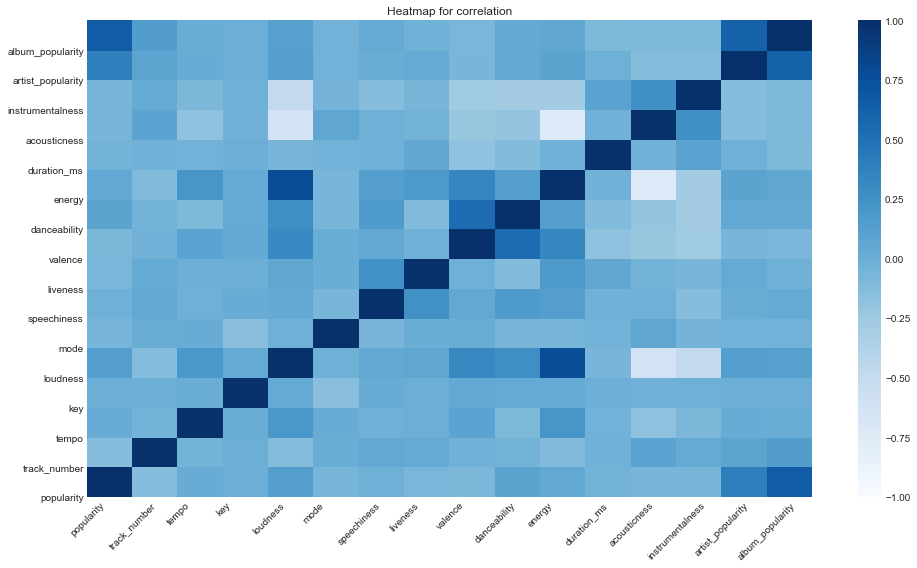

In [9]:
cor = df.corr()
heatmap = plt.pcolor(cor, vmin = -1,vmax = +1 ,cmap=matplotlib.cm.Blues)
xticks(arange(0,17),cor.columns,rotation = 45)
yticks(arange(0,17),cor.columns)
plt.title("Heatmap for correlation")
plt.colorbar(heatmap)
plt.tight_layout()
plt.show()
plt.savefig('heatmap.png')

In [10]:
cor

,popularity,track_number,tempo,key,loudness,mode,speechiness,liveness,valence,danceability,energy,duration_ms,acousticness,instrumentalness,artist_popularity,album_popularity
popularity,1.000000,-0.140607,0.018261,-0.005194,0.142993,-0.056127,-0.022758,-0.073080,-0.081783,0.088680,0.050217,-0.046621,-0.069628,-0.058752,0.391944,0.658416
track_number,-0.140607,1.000000,-0.044018,-0.004586,-0.117529,0.012708,0.048655,0.032218,-0.025620,-0.045300,-0.103493,-0.026621,0.097890,0.028050,0.079350,0.154069
tempo,0.018261,-0.044018,1.000000,0.003962,0.197522,0.020858,-0.022764,-0.006816,0.095975,-0.097847,0.212582,-0.035836,-0.173538,-0.083962,0.017051,0.014831
key,-0.005194,-0.004586,0.003962,1.000000,0.031452,-0.146614,0.019343,-0.003968,0.046079,0.031672,0.036072,-0.003344,-0.028739,-0.020783,-0.000511,-0.006848
loudness,0.142993,-0.117529,0.197522,0.031452,1.000000,-0.020387,0.046178,0.070677,0.322556,0.272746,0.774887,-0.069424,-0.626553,-0.482782,0.147412,0.131144
mode,-0.056127,0.012708,0.020858,-0.146614,-0.020387,1.000000,-0.069140,0.005011,0.010908,-0.058775,-0.061648,-0.038565,0.073783,-0.048081,-0.032928,-0.035814
speechiness,-0.022758,0.048655,-0.022764,0.019343,0.046178,-0.069140,1.000000,0.251387,0.053861,0.167509,0.143157,-0.030163,-0.016482,-0.133878,0.013661,0.032577
liveness,-0.073080,0.032218,-0.006816,-0.003968,0.070677,0.005011,0.251387,1.000000,-0.021039,-0.113405,0.185259,0.061333,-0.040631,-0.067614,0.032132,-0.018191
valence,-0.081783,-0.025620,0.095975,0.046079,0.322556,0.010908,0.053861,-0.021039,1.000000,0.537144,0.337102,-0.176504,-0.211083,-0.270174,-0.056610,-0.074514
danceability,0.088680,-0.045300,-0.097847,0.031672,0.272746,-0.058775,0.167509,-0.113405,0.537144,1.000000,0.138274,-0.116868,-0.197601,-0.276791,0.045049,0.039861


### <font color='green'>From the heatmap,correlation matrix, we could observe that energy audio feature and loudness audio feature of the track are highly (positive)correlated.Energy and loudeness are highly(negative) correlated with accousticness feature of the track.We also obeserve that , there is positive correlation between popularity of the track and artist_popularity and album_popularity. </font>



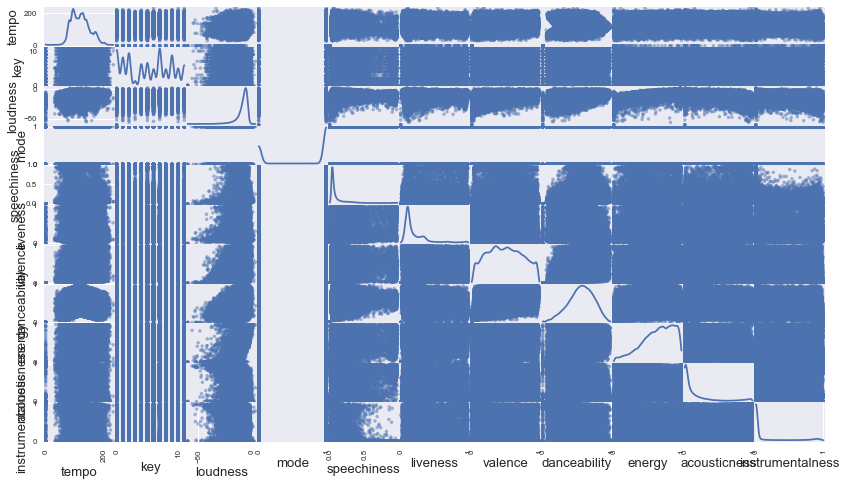

In [81]:
scatter = df[['tempo','key','loudness','mode','speechiness','liveness','valence','danceability','energy','acousticness','instrumentalness']].copy()
pd.plotting.scatter_matrix(scatter, diagonal='kde')
plt.show()

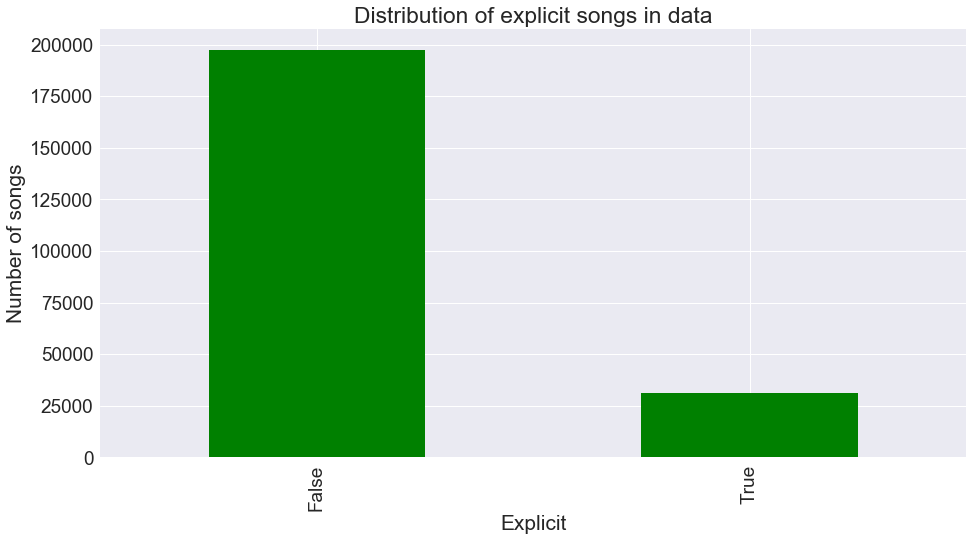

In [15]:
#Spotify tracks may include explicit content, however labels the track as EXPLICIT on any releases  
#If listerner dosen't want to hear anything explicit, he/she can check for the clean version of a track.

#plot to observe the ratio on explicit and non-eplicit tracks on spotify
df['explicit'].value_counts().plot(kind='bar', color = 'green')
plt.xlabel("Explicit")
plt.ylabel("Number of songs")
plt.title("Distribution of explicit songs in data")
plt.tight_layout()
plt.show()
plt.savefig('name.pdf')

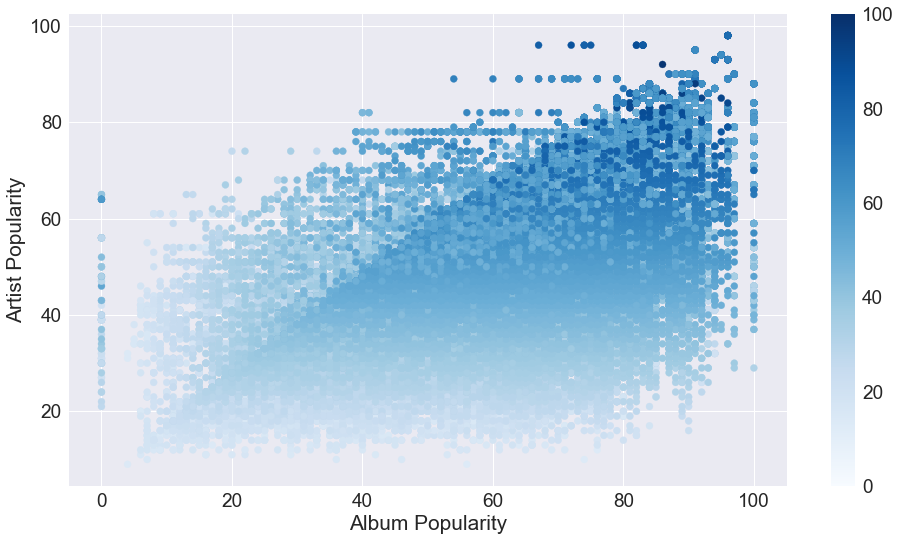

In [16]:
# your code goes here
#plt.scatter(train.Latitude,train.Longitude,c=train.LstPrice,alpha=0.5)
p = plt.scatter(df.artist_popularity,df.album_popularity,c = df.popularity, vmin = 0, vmax = 100 ,cmap=matplotlib.cm.Blues)
plt.xlabel('Album Popularity')
plt.ylabel('Artist Popularity')
plt.colorbar(p)
plt.tight_layout()
plt.show()

From the above scatterplot , we could observe the trend of track popularity based on album_popularity and artist_popularity

In our Final Submission , we will be further analysing data to answer following questions

1) Has any album size changed over the years?

2) Has the average time per track changed over the years?

3) How average popularity of a specific genre has changed over the years

*As spotify does not label any track with a genre, we will be using genre avalaible for an artist and tag the track it with most repated word from the list 

4) Average popularity of explicit track(listener could hear as intended by the artist) is higher than non-explict tracks.

5) Analyse which variables/features and machine learning algorithm are best to predict the popularity of the track.

# <font color='Orange'>2 - Data Visualization</font>

## <font color='Orange'>2.1 Visualizing Univariate Distributions - Histograms/KDE</font>

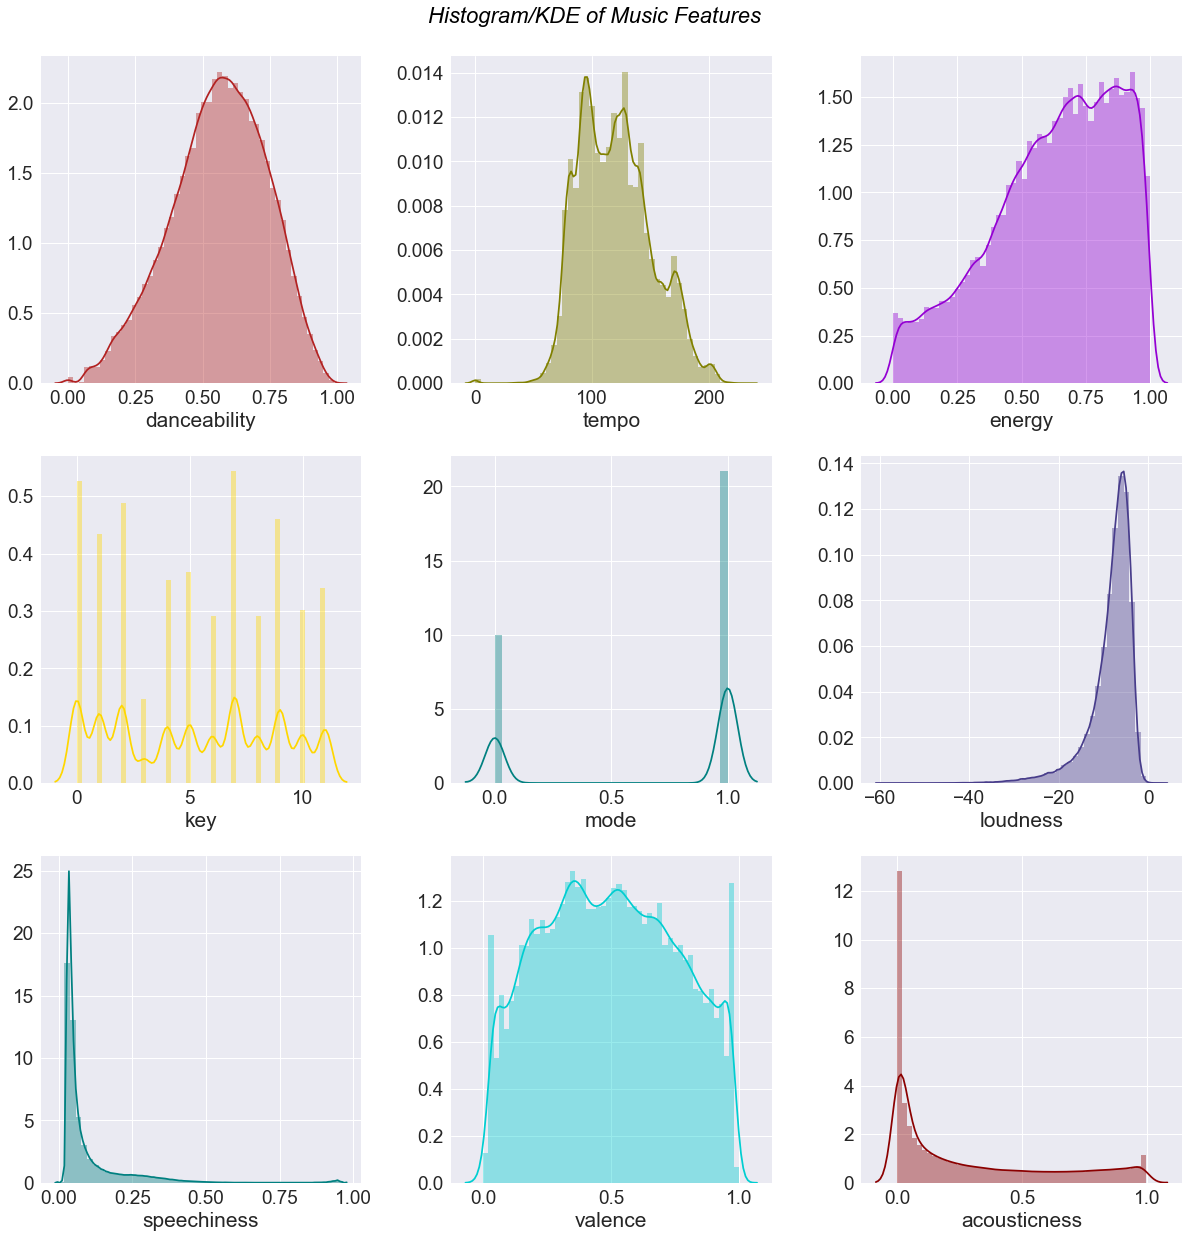

In [12]:
sns.set(font_scale=1.9)
f, axes = plt.subplots(3,3, sharex=False)

f.set_figheight(17)
f.set_figwidth(17)


left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .25     # the amount of width reserved for blank space between subplots
hspace =  0.3   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left = left, bottom = bottom, right = right, top = top, wspace = wspace, hspace = hspace)

sns.distplot( df["acousticness"] , color="darkred", ax=axes[2, 2])
sns.distplot( df["tempo"] , color="olive", ax=axes[0, 1])
sns.distplot( df["key"] , color="gold", ax=axes[1, 0])
sns.distplot( df["mode"] , color="teal", ax=axes[1, 1])
sns.distplot( df["speechiness"] , color="teal", ax=axes[2, 0])
sns.distplot( df["valence"] , color="darkturquoise", ax=axes[2, 1])
sns.distplot( df["danceability"] , color="firebrick", ax=axes[0, 0])
sns.distplot( df["loudness"] , color="darkslateblue", ax=axes[1, 2])
sns.distplot( df["energy"] , color="darkviolet", ax=axes[0, 2])

plt.suptitle("Histogram/KDE of Music Features", fontsize=22, fontweight=0, color='black', style='italic', y=1.02)
plt.tight_layout()
plt.show()
plt.savefig('music_histogram.png')

## <font color='Orange'>2.2 Visualizing Music Features Across Time </font>

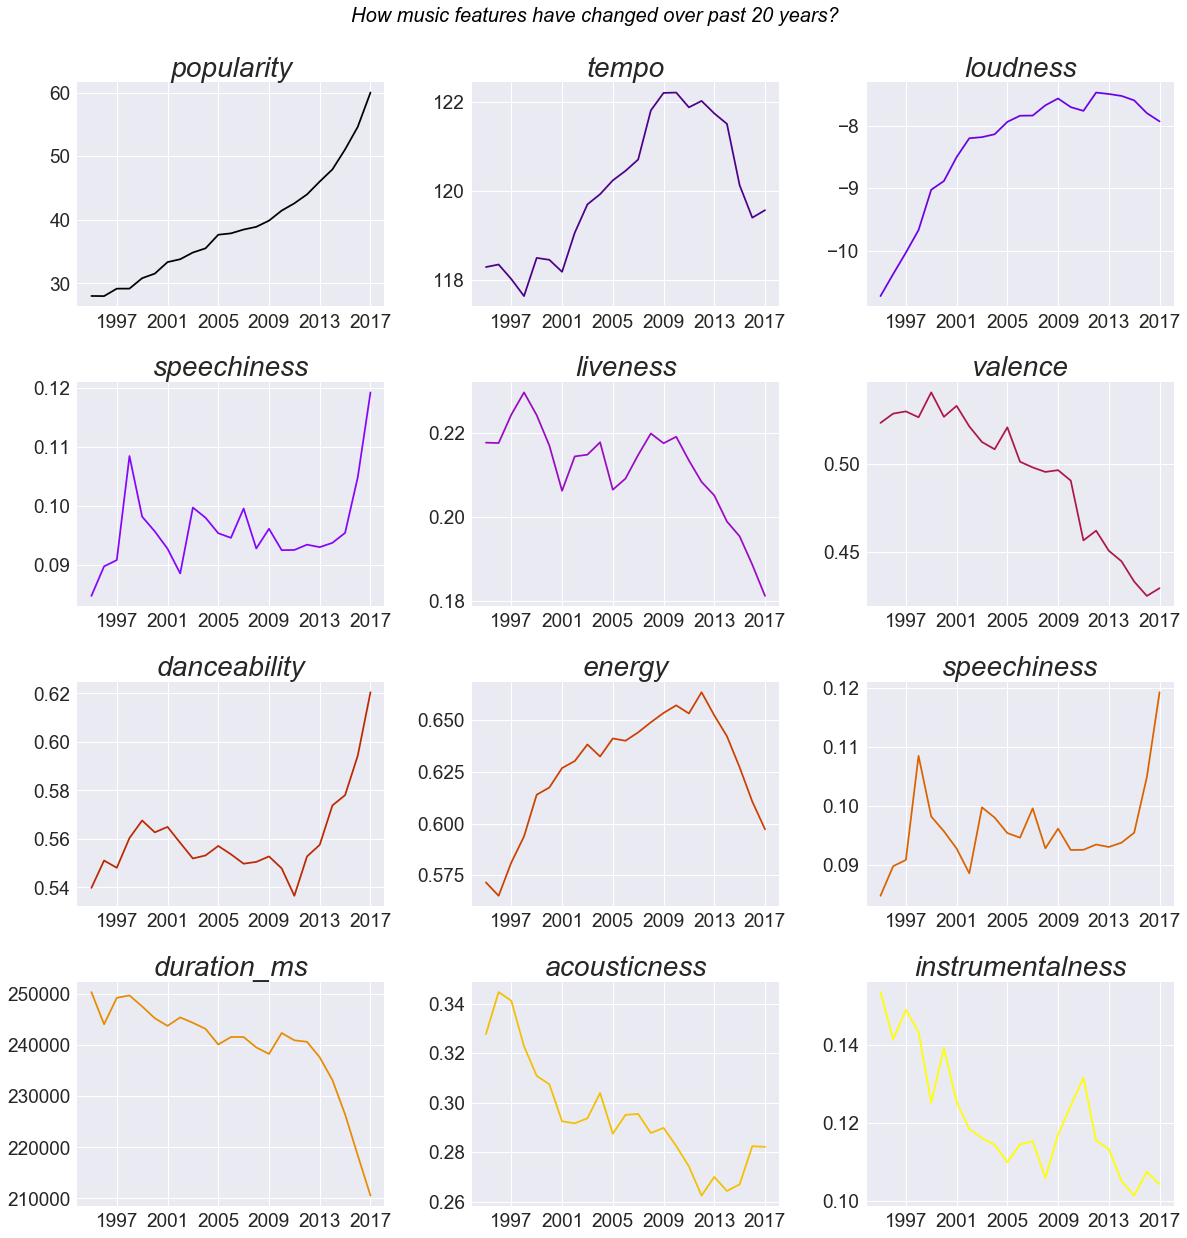

In [11]:
import matplotlib.pyplot as plt 
df1 = df.groupby('album_release_date', as_index=False)['popularity','tempo','loudness','speechiness','liveness','valence','danceability','energy','speechiness','duration_ms','acousticness','instrumentalness'].mean()

f, axes = plt.subplots(4,3, sharex=False)
f.set_figheight(17)
f.set_figwidth(17)

cmap = plt.get_cmap('gnuplot')
plt.style.use('seaborn-darkgrid')
colors = [cmap(i) for i in np.linspace(0, 1, 12)]

for i, color in enumerate(colors, start=1):
    plt.subplot(4,3,i) 
    plt.plot(df1.iloc[:,0], df1.iloc[:,i], color = color)
    plt.title(df1.columns.get_values()[i], fontsize=28, style='oblique')

plt.tight_layout()
plt.suptitle("How music features have changed over past 20 years?", fontsize=20, fontweight=0, color='black', style='italic', y=1.02)
plt.show()


### <font color='green'>In above plots we could observe that feaures such as spechiness, dancebility in music has increased in recent years where as acousticness,intrumentalness and valence have seen a downward trend</font>

## <font color='Orange'>2.3 What is the trend of number of tracks per album for last 20 years? </font>

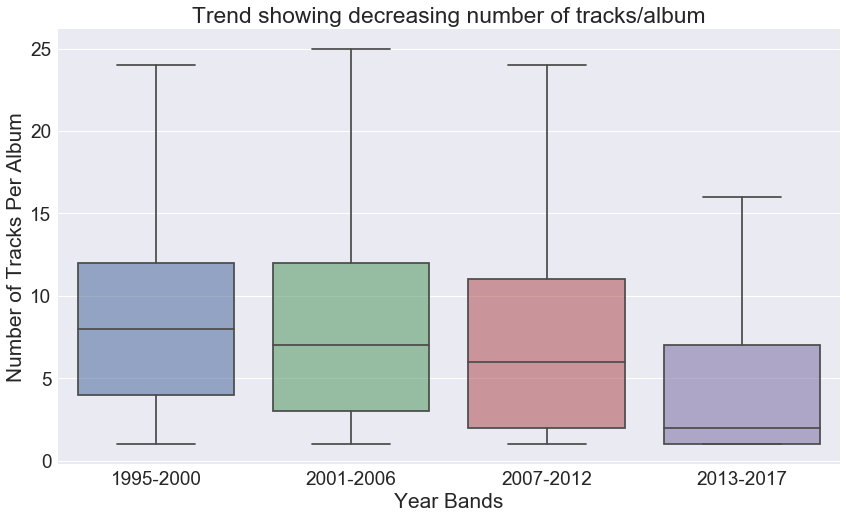

In [13]:
maximum_tracks_per_album = df.groupby(['album_name','album_release_date']).track_number.max()
maximum_tracks_per_album = maximum_tracks_per_album.to_frame()
maximum_tracks_per_album.reset_index(inplace=True) 
conditions = [
    (maximum_tracks_per_album['album_release_date'] == '1995') | (maximum_tracks_per_album['album_release_date'] == '1996') | (maximum_tracks_per_album['album_release_date'] == '1997') | (maximum_tracks_per_album['album_release_date'] == '1998') | (maximum_tracks_per_album['album_release_date'] == '1999') | (maximum_tracks_per_album['album_release_date'] == '2000'),
    (maximum_tracks_per_album['album_release_date'] == '2001') | (maximum_tracks_per_album['album_release_date'] == '2002') | (maximum_tracks_per_album['album_release_date'] == '2003') | (maximum_tracks_per_album['album_release_date'] == '2004') | (maximum_tracks_per_album['album_release_date'] == '2005') | (maximum_tracks_per_album['album_release_date'] == '2006'),
    (maximum_tracks_per_album['album_release_date'] == '2007') | (maximum_tracks_per_album['album_release_date'] == '2008') | (maximum_tracks_per_album['album_release_date'] == '2009') | (maximum_tracks_per_album['album_release_date'] == '2010') | (maximum_tracks_per_album['album_release_date'] == '2011') | (maximum_tracks_per_album['album_release_date'] == '2012'),
    (maximum_tracks_per_album['album_release_date'] == '2013') | (maximum_tracks_per_album['album_release_date'] == '2014') | (maximum_tracks_per_album['album_release_date'] == '2015') | (maximum_tracks_per_album['album_release_date'] == '2016') | (maximum_tracks_per_album['album_release_date'] == '2017')]
choices = ['1995-2000', '2001-2006', '2007-2012','2013-2017']
maximum_tracks_per_album['year_bands'] = np.select(conditions, choices, default='black')
#(maximum_tracks_per_album.head())
ax = sns.boxplot(x="year_bands", y="track_number", data=maximum_tracks_per_album, showfliers=False, order =["1995-2000", "2001-2006","2007-2012","2013-2017"])
ax.set_ylabel("Number of Tracks Per Album")
ax.set_xlabel("Year Bands")
ax.set_title("Trend showing decreasing number of tracks/album")
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
plt.savefig('music_boxplot.png')

### <font color='green'>From above boxplot, We could  observe that the median number of trackss per album has reduced from about 7 tracks/album in 1995-2000 to about 2 tracks/album in 2013-2017 </font>

## <font color='Orange'>2.4 Does explicit songs tend to be more popular than non-explicit songs on spotify? </font>

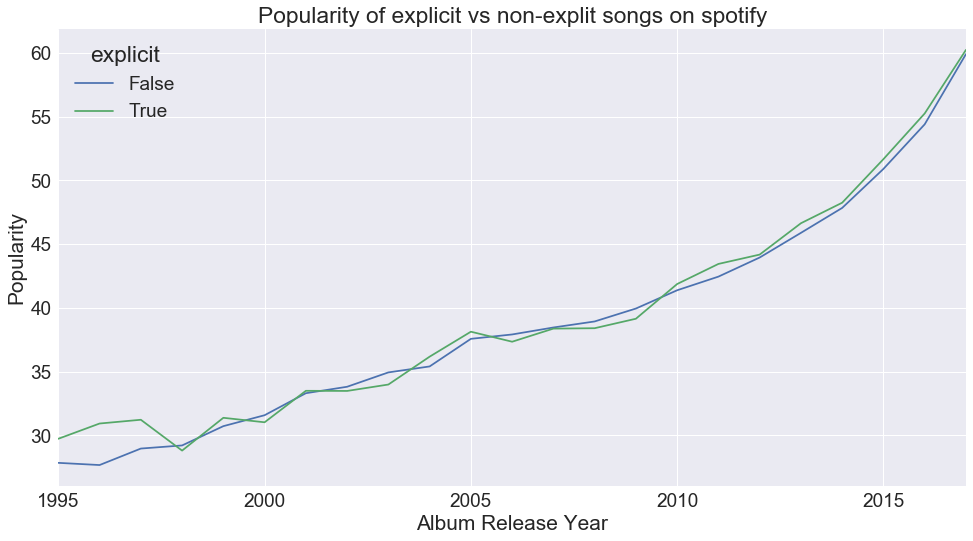

In [14]:
df1 = df.groupby(['explicit','album_release_date']).popularity.mean()
df1 = df1.to_frame()
df1.reset_index(inplace=True) 
df1 = df1.pivot(index = 'album_release_date', columns='explicit', values='popularity')
df1.plot(kind = 'line')
plt.ylabel("Popularity")
plt.xlabel("Album Release Year")
plt.title("Popularity of explicit vs non-explit songs on spotify")
plt.tight_layout()
plt.show()
plt.savefig('explicit_popularity.png')

### <font color='green'>From the above line chart, we could see that explicit songs are trending almost same as non-explicit songs, however for spotify listenrs which listen to old songs(released between 1995-1998),explicit songs are comparatively more popular.</font>

## <font color='Orange'>2.5 Visualisations for artist genre </font>

### <font color='green'> Unifortunately,spotify does not provide genre for every song. however, it does provide artist genre for every artist. using the genre we have below counted the most popular genre among artist and have compared the top 5 artist genre for popularity .</font>

In [15]:
#Reading the data which was saved after reducing the artist genre to single word
df1= pd.read_csv('musicdata.csv', error_bad_lines=False)
# dropping the observations which have NaN values
df1 = df1.dropna()
# dropping the columns which will not be useful
#df1.album_release_date = df1.album_release_date.astype("category")
df1['album_release_date'] = df1['album_release_date'].astype('str')
df1['album_release_date'] = pd.to_datetime(df1['album_release_date'],infer_datetime_format=True)

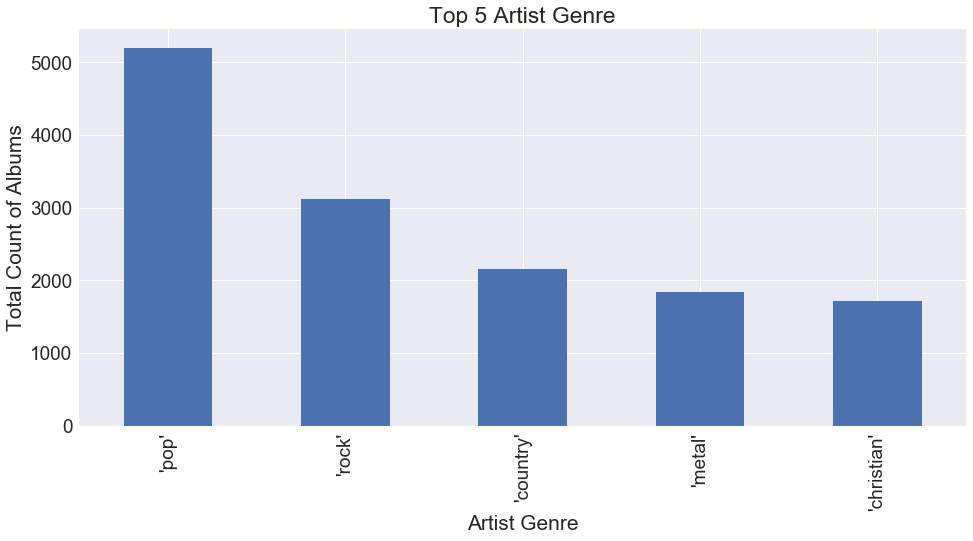

In [16]:
#grouping by artist_genre,album_release_date,artist_name at every year level
df1 = df1.groupby(['artist_genres','album_release_date','artist_name']).popularity.mean()
df1 = df1.to_frame()
df1.reset_index(inplace=True) 
#plotting bargraph to take the top 5 genre counts
df1['artist_genres'].value_counts().head(5).plot(kind='bar')
plt.xlabel("Artist Genre")
plt.ylabel("Total Count of Albums")
plt.title("Top 5 Artist Genre")
plt.tight_layout()
plt.show()
plt.savefig('top_5_artist.png')

### <font color='green'> Above, we could obsrve that most of the albums are from the pop genre artists , followed by rock,country, metal and christian.</font>

In [17]:
df1 = df1[(df1['artist_genres']=="'rock'")|(df1['artist_genres']=="'pop'")|(df1['artist_genres']=="'metal'")|(df1['artist_genres']=="'country'")|(df1['artist_genres']=="'christian'")]
df1 = df1.groupby(['artist_genres','album_release_date']).popularity.mean()
df1 = df1.to_frame()
df1.reset_index(inplace=True) 
df1 = df1.pivot(index = 'album_release_date', columns='artist_genres', values='popularity')

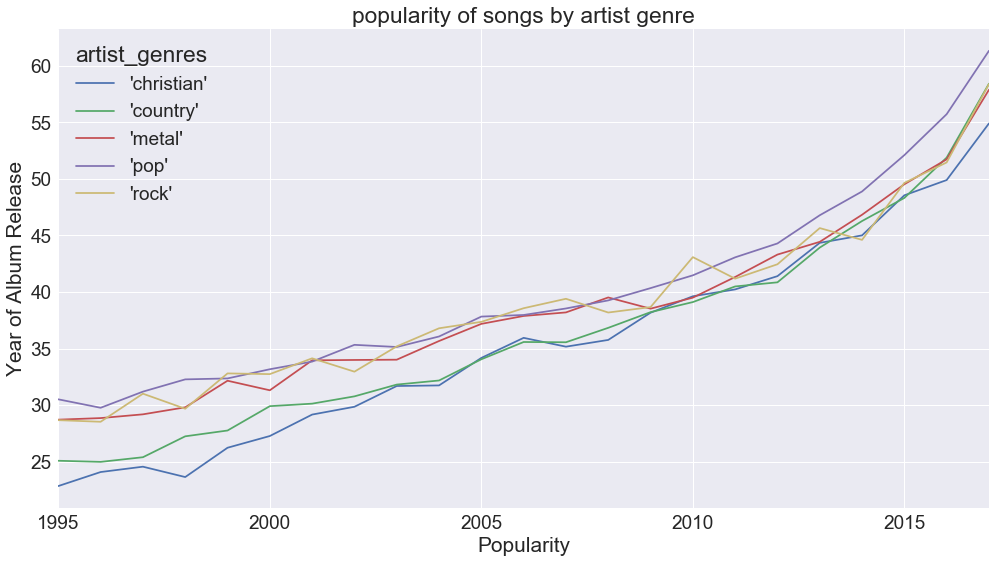

In [23]:
df1.plot()
plt.tight_layout()
plt.title("popularity of songs by artist genre")
plt.xlabel("Popularity")
plt.ylabel('Year of Album Release')
plt.show()
plt.savefig('popularity_by_artist.png')

## <font color='Orange'>2.6 Any insightful plot on Popularity? </font>

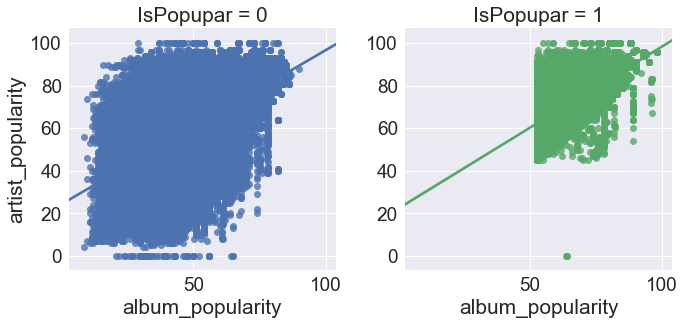

In [18]:
df1 = df.copy()
df1['IsPopupar'] = np.where(df1['popularity']>=60, 1, 0)
sns.lmplot(x="album_popularity", y="artist_popularity", hue="IsPopupar", col="IsPopupar", data=df1, x_jitter=.1)
plt.tight_layout()
plt.show()
plt.savefig('popularity_regression.png')

### <font color='green'>From above seaborn lmplot,for a track to be popular on spotify - it must have both album popularity and artist popularity above 50. At the same time , there is no garantee that if album and artist both are  popualar the track will be popular. </font>

## <font color='Orange'>2.7 Popularity Analysis by numeric feature </font>

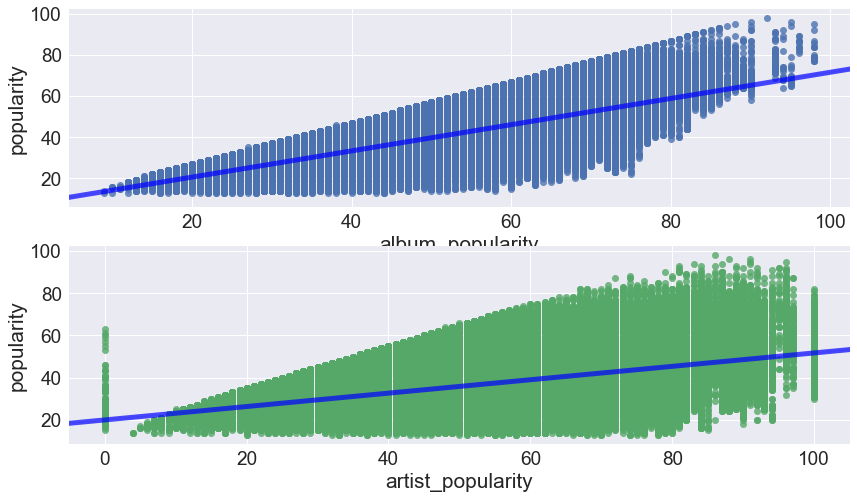

In [34]:
f, (ax1, ax2) = plt.subplots(2)
sns.regplot(x="album_popularity", y="popularity", data = df, line_kws={"color":"b","alpha":0.7,"lw":5}, ax = ax1)
sns.regplot(x="artist_popularity", y="popularity", data = df, line_kws={"color":"b","alpha":0.7,"lw":5}, ax = ax2) 

 ### <font color='green'>There is a linear relationship between the popularity of the album with song popularity and so is with with the artist popluarity. Meaning the album's popularity increases with songs popularity. The same trend is seen in artist popularity, meaning the chances of a popular song increses with the artist's popularity.</font>

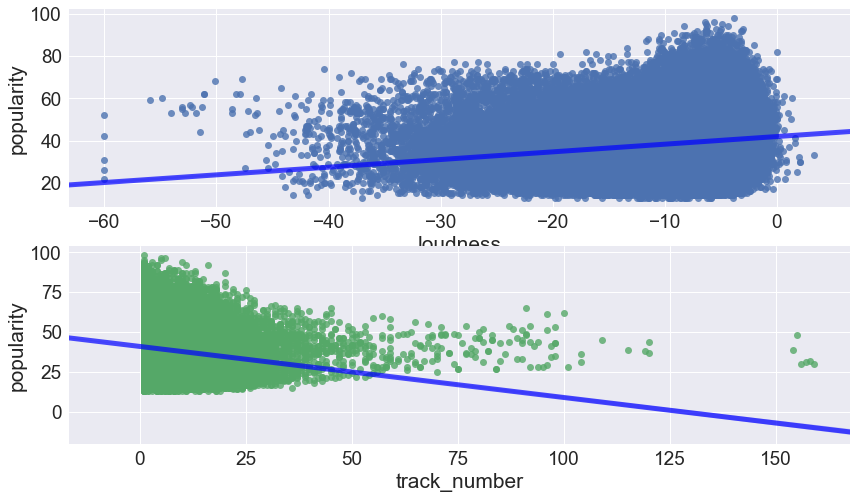

In [35]:
f, (ax1, ax2) = plt.subplots(2)
sns.regplot(x=df["loudness"], y=df["popularity"], line_kws={"color":"b","alpha":0.7,"lw":5}, ax = ax1)
sns.regplot(x=df["track_number"], y=df["popularity"], line_kws={"color":"b","alpha":0.7,"lw":5}, ax= ax2)

### <font color='green'>We can see a weak possitive realtion with loudness and popularity, the popularity of a song increases with loudness where as on other hand popularity of a song decreases with increase of nuber of tracks in an album.</font>

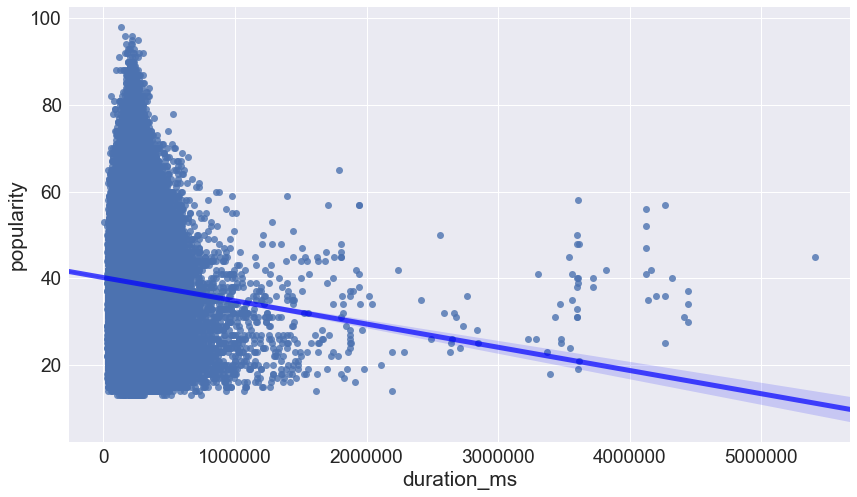

In [36]:
sns.regplot(x=df["duration_ms"], y=df["popularity"], line_kws={"color":"b","alpha":0.7,"lw":5})

### <font color='green'>Here we can see that the popularity of the song reduces as the song length increases. </font>

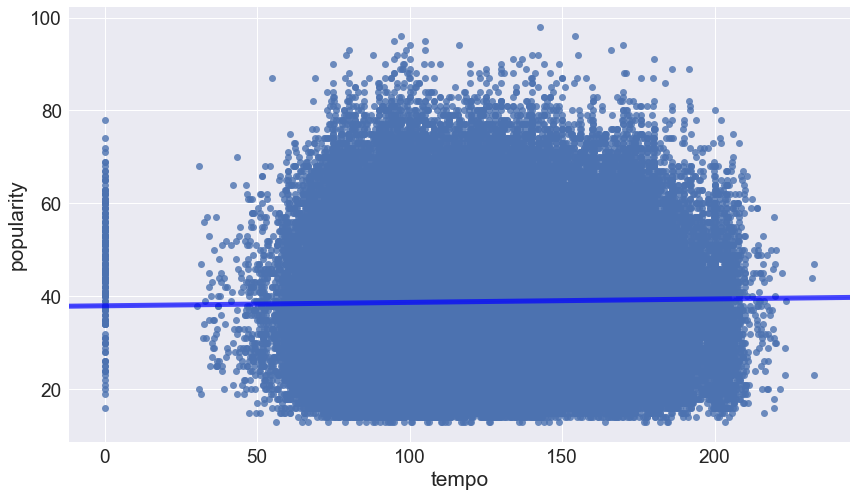

In [37]:
sns.regplot(x=df["tempo"], y=df["popularity"], line_kws={"color":"b","alpha":0.7,"lw":5})

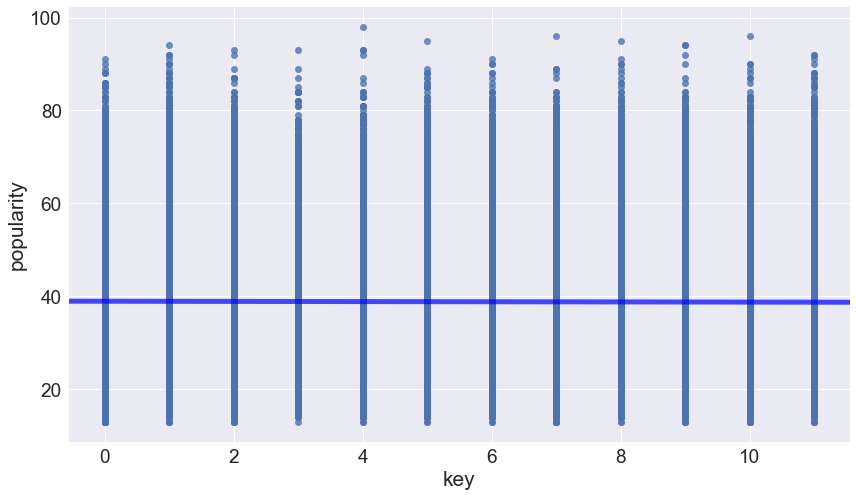

In [38]:
sns.regplot(x=df["key"], y=df["popularity"], line_kws={"color":"b","alpha":0.7,"lw":5})

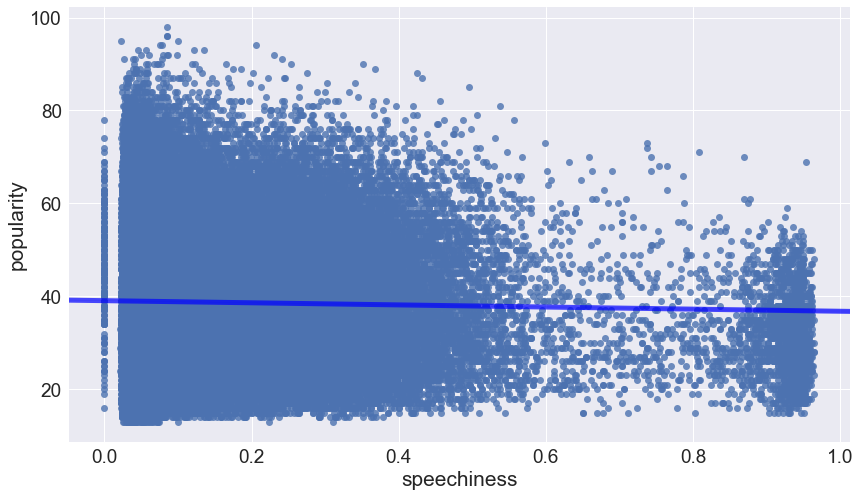

In [39]:
sns.regplot(x=df["speechiness"], y=df["popularity"], line_kws={"color":"b","alpha":0.7,"lw":5})

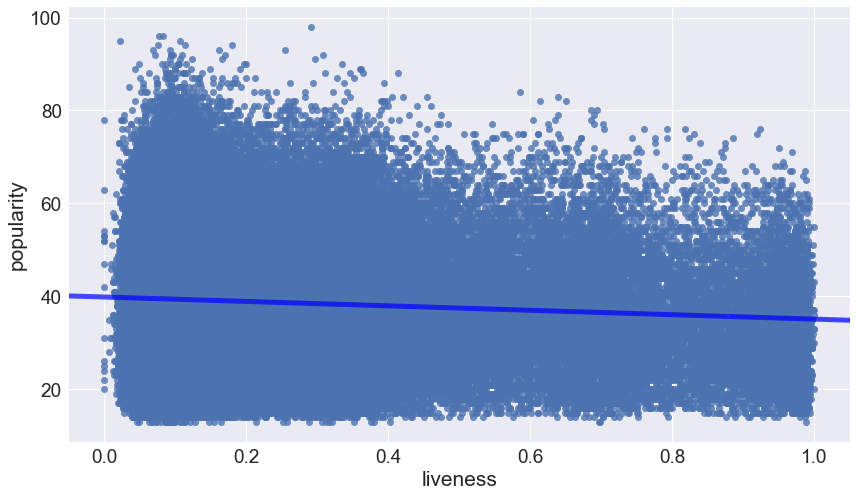

In [40]:
sns.regplot(x=df["liveness"], y=df["popularity"], line_kws={"color":"b","alpha":0.7,"lw":5})

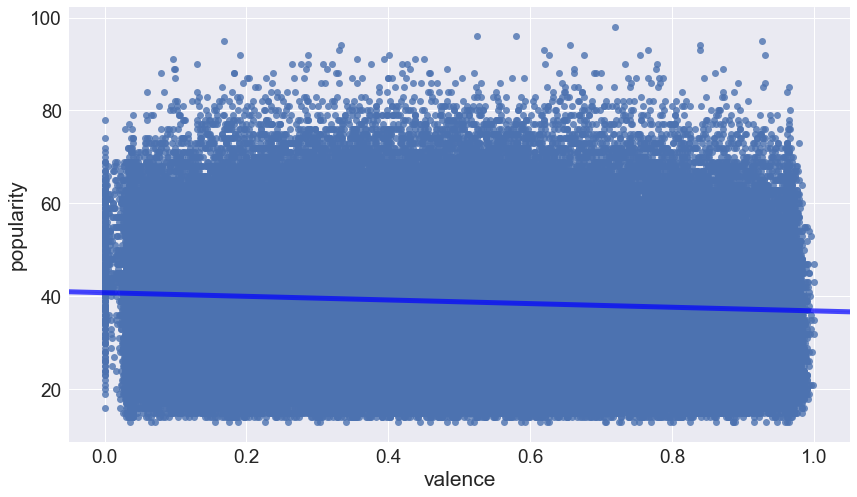

In [41]:
sns.regplot(x=df["valence"], y=df["popularity"], line_kws={"color":"b","alpha":0.7,"lw":5})

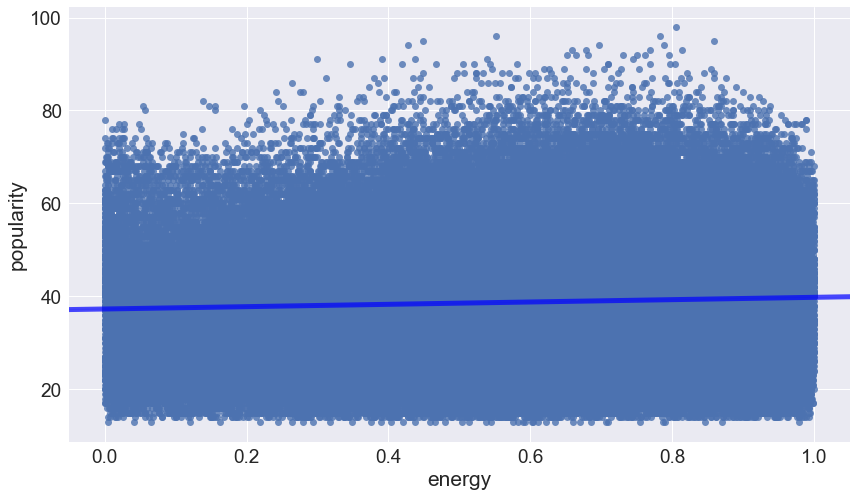

In [42]:
sns.regplot(x=df["energy"], y=df["popularity"], line_kws={"color":"b","alpha":0.7,"lw":5})

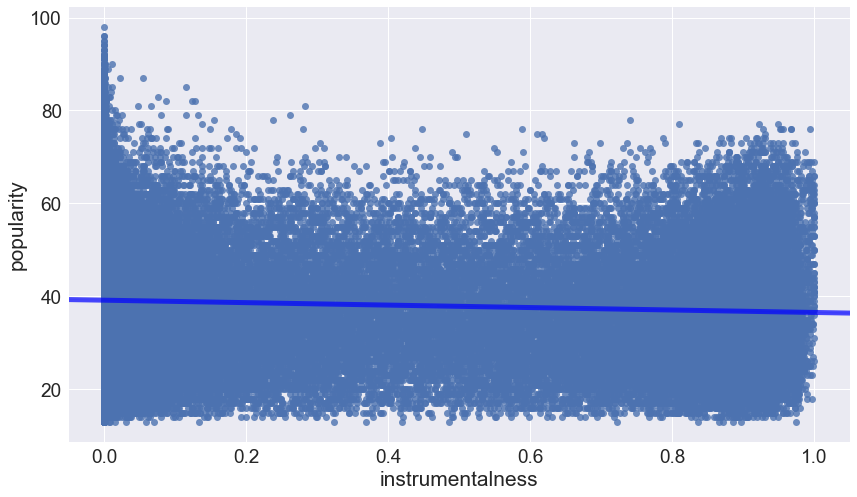

In [43]:
sns.regplot(x=df["instrumentalness"], y=df["popularity"], line_kws={"color":"b","alpha":0.7,"lw":5})

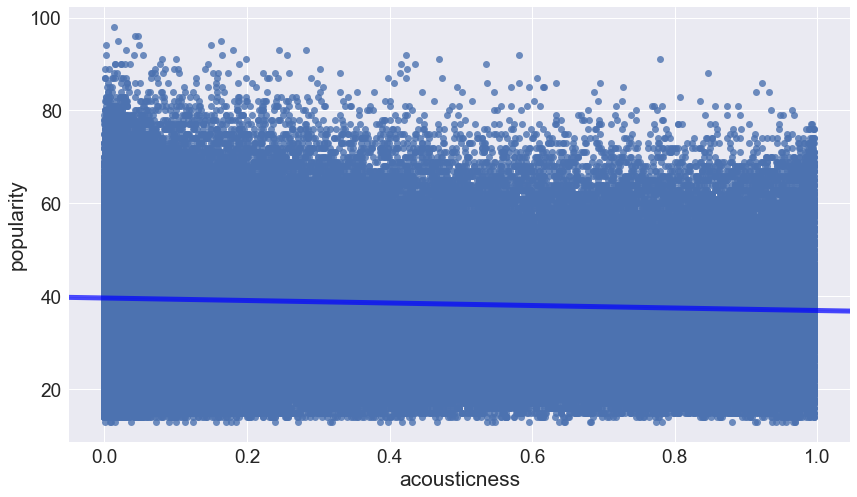

In [44]:
sns.regplot(x=df["acousticness"], y=df["popularity"], line_kws={"color":"b","alpha":0.7,"lw":5})

### <font color='green'>Above we can see that there is very little to no relationship between any function of song with the popularity of the song. </font>

# <font color='Orange'>3 - Regression Analysis </font>

## <font color='Orange'>3.1 Linear regression to check if any track features explain popularity of the song </font>

In [25]:
feature_ols = sm.ols(formula="popularity ~  explicit + tempo + loudness + mode + speechiness + liveness + valence + danceability + energy + duration_ms + acousticness + instrumentalness",  data=df).fit()
feature_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     1584.
Date:                Sat, 21 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:10:56   Log-Likelihood:            -8.9228e+05
No. Observations:              229003   AIC:                         1.785e+06
Df Residuals:                  228990   BIC:                         1.785e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           45.8001      0.267    171.349      0.000      45.276      46.324
explicit[T.True]     3.4642      0.084     41.461      0.000       3.300       3.628
tempo                0.0096      0.001     11.347      0.000       0.008       0.011
loudness             0.5453      0.009     57.962      0.000       0.527       0.564
mode                -1.1805      0.054    -21.872      0.000      -1.286      -1.075
speechiness         -6.8536      0.239    -28.624      0.000      -7.323      -6.384
liveness            -3.5213      0.141    -25.021      0.000      -3.797      -3.245
valence            -10.0754      0.126    -79.673      0.000     -10.323      -9.828
danceability         9.3941      0.188     50.026      0.000       9.026       9.762
energy              -1.8277      0.205     -8.902      0.000      -2.230      -1.425
duration_ms      -5.936e-06   2.37e-07    -25.074      0.000    -6.4e-06   -5.47e-06
acousticness         1.3556      0.119     11.416      0.000       1.123       1.588
instrumentalness     0.5418      0.108      4.998      0.000       0.329       0.754
==============================================================================
Omnibus:                     7129.157   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7819.455
Skew:                           0.453   Prob(JB):                         0.00
Kurtosis:                       2.988   Cond. No.                     3.65e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### <font color='green'>We wanted to check if the features of the song explain the variability in the popularity, by running the linear regression model, we get R-squared of 0.07% which indicates there is no variability in our dataset, probably having genre of song would have helped , unfortunately spotify has stopped tagging the song genre in their api and that variable was not available for analysis.</font>

## <font color='Orange'>3.2 Which features best explain the 'popularity' of the song in the dataset? </font>

In [26]:
best_ols = sm.ols(formula="popularity ~  artist_popularity + album_release_date",  data=df).fit()
best_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                 1.046e+04
Date:                Sat, 21 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:11:08   Log-Likelihood:            -8.1920e+05
No. Observations:              229003   AIC:                         1.638e+06
Df Residuals:                  228979   BIC:                         1.639e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 18.0269      0.110    164.263      0.000      17.812      18.242
album_release_date[T.Timestamp('1996-01-01 00:00:00')]     0.2091      0.123      1.706      0.088      -0.031       0.449
album_release_date[T.Timestamp('1997-01-01 00:00:00')]     1.1799      0.123      9.601      0.000       0.939       1.421
album_release_date[T.Timestamp('1998-01-01 00:00:00')]     1.3151      0.122     10.742      0.000       1.075       1.555
album_release_date[T.Timestamp('1999-01-01 00:00:00')]     2.6908      0.122     21.978      0.000       2.451       2.931
album_release_date[T.Timestamp('2000-01-01 00:00:00')]     3.4009      0.122     27.778      0.000       3.161       3.641
album_release_date[T.Timestamp('2001-01-01 00:00:00')]     5.0058      0.123     40.779      0.000       4.765       5.246
album_release_date[T.Timestamp('2002-01-01 00:00:00')]     5.2420      0.122     42.798      0.000       5.002       5.482
album_release_date[T.Timestamp('2003-01-01 00:00:00')]     6.3528      0.122     51.872      0.000       6.113       6.593
album_release_date[T.Timestamp('2004-01-01 00:00:00')]     6.9126      0.122     56.433      0.000       6.673       7.153
album_release_date[T.Timestamp('2005-01-01 00:00:00')]     9.0350      0.122     73.758      0.000       8.795       9.275
album_release_date[T.Timestamp('2006-01-01 00:00:00')]     9.0958      0.123     74.138      0.000       8.855       9.336
album_release_date[T.Timestamp('2007-01-01 00:00:00')]     9.7877      0.123     79.793      0.000       9.547      10.028
album_release_date[T.Timestamp('2008-01-01 00:00:00')]    10.1271      0.123     82.648      0.000       9.887      10.367
album_release_date[T.Timestamp('2009-01-01 00:00:00')]    10.9163      0.123     89.046      0.000      10.676      11.157
album_release_date[T.Timestamp('2010-01-01 00:00:00')]    12.2831      0.123    100.128      0.000      12.043      12.524
album_release_date[T.Timestamp('2011-01-01 00:00:00')]    13.3663      0.123    108.933      0.000      13.126      13.607
album_release_date[T.Timestamp('2012-01-01 00:00:00')]    14.6166      0.123    118.904      0.000      14.376      14.858
album_release_date[T.Timestamp('2013-01-01 00:00:00')]    16.4050      0.123    133.475      0.000      16.164      16.646
album_release_date[T.Timestamp('2014-01-01 00:00:00')]    18.1912      0.123    147.364      0.000      17.949      18.433
album_release_date[T.Timestamp('2015-01-01 00:00:00')]    20.9809      0.124    169.845      0.000      20.739      21.223
album_release_date[T.Timestamp('2016-01-01 00:00:00')]    24.5351      0.124    198.604      0.000      24.293      24.777
album_re

### <font color='green'>After trying several regression models, using backward elimination method, we found the album rlease year and artist popularity are the two best variables that explain the popularity of a song, we could observe that that coefficient for the categorical variable album_release_year is increasing for every year which indicates that the recent released tracks tend to be popular among spotify users and increases by 0.18 units for every 1 unit increase in artist popularity</font>

### <font color='green'>Note: We have excluded the variable album popularity from regression model as it is the average popularity of the songs in the album i.e. calculated based on popularity </font>

## <font color='Orange'>3.3 Linear regression in predicting popularity of the song </font>

In [27]:
df1 = df.drop(["song_name","artist_name","album_name", "artist_genres",'album_popularity'], axis=1)
df1.album_release_date = df1.album_release_date.astype("category")
df1.head()

,popularity,explicit,track_number,tempo,key,loudness,mode,speechiness,liveness,valence,danceability,energy,duration_ms,acousticness,instrumentalness,artist_popularity,album_release_date
0,75,False,3,174.530,2.0,-4.918,1.0,0.0381,0.234,0.478,0.372,0.865,258733.0,0.000453,0.000000,81,1995-01-01
1,65,False,4,162.978,0.0,-4.087,1.0,0.0592,0.126,0.335,0.333,0.922,289559.0,0.059600,0.000002,81,1995-01-01
2,64,False,12,150.272,2.0,-4.625,1.0,0.0388,0.364,0.120,0.286,0.796,448438.0,0.470000,0.063000,81,1995-01-01
3,49,False,9,125.413,9.0,-4.288,1.0,0.0475,0.636,0.526,0.494,0.893,219799.0,0.164000,0.000002,81,1995-01-01
4,47,False,7,108.954,0.0,-3.115,0.0,0.0896,0.285,0.072,0.263,0.921,327839.0,0.162000,0.013000,81,1995-01-01


In [28]:
#creating set of independent variable X
X = df1.iloc[:,1:17].values
#creating vector of dependent variable y
y = df1.iloc[:,0].values

In [29]:
# Encoding 'explicit'categorical variable 
labelencoder_X = LabelEncoder()
X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
onehotencoder = OneHotEncoder(categorical_features = [0])
X = onehotencoder.fit_transform(X).toarray()
#taking care of dummy-variable trap
X = X[:,1:]

In [30]:
#Encoding 'album_relase_year' categorical variable
labelencoder_X = LabelEncoder()
X[:, 15] = labelencoder_X.fit_transform(X[:, 15])
onehotencoder = OneHotEncoder(categorical_features = [15])
X = onehotencoder.fit_transform(X).toarray()
#taking care of dummy variable trap
X = X[:,1:]

In [31]:
#deviding the dependent and independent variable in train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [32]:
#using sklearns linearRegression method to predict popuarity of the song
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

In [33]:
#applying sklearn r2_score method to find test rsquared value
print("the test r-squared in linear regression model is", r2_score(y_test, y_pred))

the test r-squared in linear regression model is 0.525314899008


In [34]:
#applying sklearn cross_val_score on linear regressor to find test validation score
scores = cross_val_score(regressor, X_train, y_train, cv=5, n_jobs = -1)
print("The cross validation r-squared in predicting popularity of song using linear regression is",scores.mean()) 

The cross validation r-squared in predicting popularity of song using linear regression is 0.524115718775


### <font color='green'> In linear regression method, We get cross validation r-squared of about 52% , which is not a good r2 value so decided to use random forest which is more robust and could handle the non-linear data </font>

## <font color='Orange'>3.4 Random forest regression to predict popularity of the song </font>

In [35]:
#using sklearns RandomForestRegressor method to predict popuarity of the song
from sklearn.ensemble import RandomForestRegressor
Regressor = RandomForestRegressor(n_estimators = 100)
Regressor.fit(X_train,y_train)
y_pred = Regressor.predict(X_test)

In [36]:
#applying sklearn r2_score method to find test rsquared value
print("the test r-squared in random forest regression model is", r2_score(y_test, y_pred))

the test r-squared in random forest regression model is 0.549355121831


In [37]:
#applying sklearn cross_val_score on random forest regressor to find test validation score
scores = cross_val_score(Regressor, X_train, y_train, cv=5, n_jobs = -1)
print("The cross validation r2 in predicting popularity of songs using random forest regressor is",scores.mean())

The cross validation r2 in predicting popularity of songs using random forest regressor is 0.543533872341


### <font color='green'> We did not get much success in improving rsqured value using random forest regression and got an rsquared value of 54%, considering the problem at hand we decided to convert our regression task into classifcation task as our main aim was to predict if the song will be popular song. </font>

# <font color='Orange'> 4 - Classification </font>

### We have created new column "IsPopular" which we will be using as binary dependent variable for classification models. IsPopular variable will take value 1 if popularity greater than 60 else 0.

In [56]:
#Creating new variable IsPopular which will take 1 if popularity greater than 60 else 0. 
df['IsPopupar'] = np.where(df['popularity']>=60, 1, 0)
df = df.drop(['popularity',"song_name","artist_name","album_name","album_popularity","artist_genres" ], axis=1)
df.album_release_date = df.album_release_date.astype("category")

In [49]:
df.head()

,explicit,track_number,tempo,key,loudness,mode,speechiness,liveness,valence,danceability,energy,duration_ms,acousticness,instrumentalness,artist_popularity,album_release_date,IsPopupar
0,False,3,174.530,2.0,-4.918,1.0,0.0381,0.234,0.478,0.372,0.865,258733.0,0.000453,0.000000,81,1995-01-01,1
1,False,4,162.978,0.0,-4.087,1.0,0.0592,0.126,0.335,0.333,0.922,289559.0,0.059600,0.000002,81,1995-01-01,1
2,False,12,150.272,2.0,-4.625,1.0,0.0388,0.364,0.120,0.286,0.796,448438.0,0.470000,0.063000,81,1995-01-01,1
3,False,9,125.413,9.0,-4.288,1.0,0.0475,0.636,0.526,0.494,0.893,219799.0,0.164000,0.000002,81,1995-01-01,0
4,False,7,108.954,0.0,-3.115,0.0,0.0896,0.285,0.072,0.263,0.921,327839.0,0.162000,0.013000,81,1995-01-01,0


## <font color='Orange'>4.1  Gaussian Naive Bayes </font>

In [57]:
#creating set of independent variable
X = df.iloc[:,0:16].values
#creating vector of dependent variable
y = df.iloc[:,16].values

In [58]:
# Encoding 'explicit'categorical variable 
labelencoder_X = LabelEncoder()
X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
onehotencoder = OneHotEncoder(categorical_features = [0])
X = onehotencoder.fit_transform(X).toarray()
#taking care of dummy-variable trap
X = X[:,1:]

In [59]:
# Encoding'album_relase_year' categorical variable 
labelencoder_X = LabelEncoder()
X[:, 15] = labelencoder_X.fit_transform(X[:, 15])
onehotencoder = OneHotEncoder(categorical_features = [15])
X = onehotencoder.fit_transform(X).toarray()
#taking care of dummy variable trap
X = X[:,1:]

In [60]:
#deviding the dependent and independent variable in train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### <font color='Orange'>4.1.1 Applying principal component analysis to reduce the number of features </font>

In [61]:
#Standardizing the X_train and X_test as part of preprocessing
from sklearn.preprocessing import StandardScaler
sc_X_train = StandardScaler()
sc_X_test = StandardScaler()
X_train = sc_X_train.fit_transform(X_train)
X_test = sc_X_test.fit_transform(X_test)

In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components =  30)
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)
explained_variance = pca.explained_variance_ratio_
explained_variance

array([ 0.0860918 ,  0.04339826,  0.04085055,  0.03645175,  0.0320603 ,
        0.02965079,  0.02860467,  0.02841892,  0.02838164,  0.02830153,
        0.02828848,  0.02828539,  0.02827674,  0.02826875,  0.02826451,
        0.02826078,  0.02825499,  0.02825257,  0.02823839,  0.02823756,
        0.02822913,  0.02821547,  0.02815844,  0.02809621,  0.02772211,
        0.02642928,  0.02589618,  0.02425245,  0.02290639,  0.02091666])

### <font color='Orange'>4.1.2 Using GaussianNB algorithm to predict popularity of the song</font>

In [63]:
#creating a GaussianNB claasifier to predict popuar songs for year 2017
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
print("The test accuracy in predicting popular songs using naiveBayes is", classifier.score(X_test, y_test)) 

The test accuracy in predicting popular songs using naiveBayes is 0.925656645051


### <font color='Orange'>4.1.3 Applying cross-validation to GaussianNB classifier</font>

In [64]:
#Using cross vaidation function to predict is song is going to be popular?
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X_train, y_train, cv=10, n_jobs = -1)
print("The cross validation accuracy in predicting popular songs using naiveBayes classifer is",scores.mean()) 

The cross validation accuracy in predicting popular songs using naiveBayes classifer is 0.909487849388


### <font color='green'> We initially created numpy array of dependent and independent variables, as our dataset had two categorical variables namely explicit and album_release_year, we encoded them using sklearns LabelEncoder and OneHotEncoder and also took care of dummy variable trap.We used StandardScalar method from sklearn to standardize our data which helps in PCA and applying machine learning methods.We used principal component analysis to reduce the number of features, but had to keep it 30 as most variable were explaining only about 2% of variance maximum being 8% variance. We fitted the naive bayes algorithm (Gaussian),as it has good performance and there was no hyperparameter tuning required. The cross-validation score in predicting popularity of the song is 91% 
</font>

## <font color='Orange'>4.2  Random Forest Classification </font>

### <font color='green'>We wanted to check if we could further increase the accuracy, we initially used SVM but it was taking too long for running the model so decided to go ahead with Random Forest Classification.  </font>

### <font color='Orange'>4.1.1 Using Random Forest classification algorithm to predict popularity of the song</font>

In [72]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000,criterion='gini',n_jobs =-1) 
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
print("The test accuracy in predicting popular songs using Randomforest is", classifier.score(X_test, y_test)) 

The test accuracy in predicting popular songs using Randomforest is 0.934608414663


### <font color='Orange'>4.1.2 Applying cross-validation to random forest classifer </font>

In [73]:
#Using cross vaidation function to predict is song is going to be popular?
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs = -1)
print("The cross validation accuracy in predicting popular songs using RandomForest classifer is",scores.mean()) 

The cross validation accuracy in predicting popular songs using RandomForest classifer is 0.940148029583


### <font color='Orange'>4.1.3 Using grid search method to tune hyperparameters </font>

### <font color='green'>In the model for random forest classifier, initially, we have selected n_estimators i.e. number of trees as 10 and , criterion to be entropy, we are used grid search algorithm to tune hyperparameters and we found that we get the best accuracy for criterion = 'ginni' and n_estimators = 1000 as follows: </font>

In [74]:
from sklearn.model_selection import GridSearchCV
parameters = [ {'n_estimators': [10,100,1000], 'criterion':['entropy']},
               {'n_estimators': [10,100,1000], 'criterion':['gini']}
             ]

In [75]:
grid_search = GridSearchCV(estimator=classifier ,param_grid= parameters, scoring='accuracy',cv=2,n_jobs=-1)

In [76]:
grid_search = grid_search.fit(X_train,y_train)

In [77]:
best_accuracy = grid_search.best_score_
best_accuracy

0.94257704610211679

In [78]:
best_parameters = grid_search.best_params_
best_parameters

{'criterion': 'gini', 'n_estimators': 1000}

# <font color='Orange'> 5 - Clustering </font>
### <font color='green'>We are not provided with genre for the songs in the data, we now will be using clustering to find if we could cluster the songs based on the features of the song </font>


## <font color='Orange'> 5.1 Kmeans++ clustering </font>

### <font color='green'>Below we are using elbow method to find the number of clusters, although we were hopeful to get about 7-8 clusters as we have songs majorly devided into 7-8 genres, From elbow method we got best number of clusters to be 3 clusters</font>

In [21]:
X =  df[['tempo','key','loudness','mode','speechiness','liveness','valence','danceability','energy','acousticness','instrumentalness']].copy()
X = X.iloc[:,0:11].values

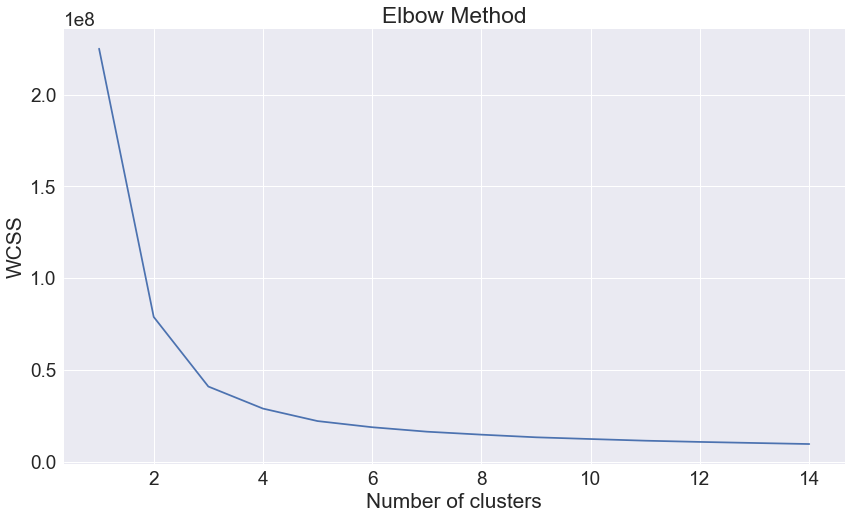

In [20]:
from sklearn.cluster import KMeans
wcss = []
for i in range (1,15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300,n_init = 10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15), wcss)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()
plt.savefig('elbow_method.png')

In [67]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300,n_init = 10)
y_kmeans = kmeans.fit_predict(X)

### <font color='green'>In clustering above , as there are more than 2 variables used, we were not be able to  plot the clusters, so below using principal component analysis we will use only 2 components which expalins the highst variability in the data and plot it </font>

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components =  2)
X = pca.fit_transform(X)

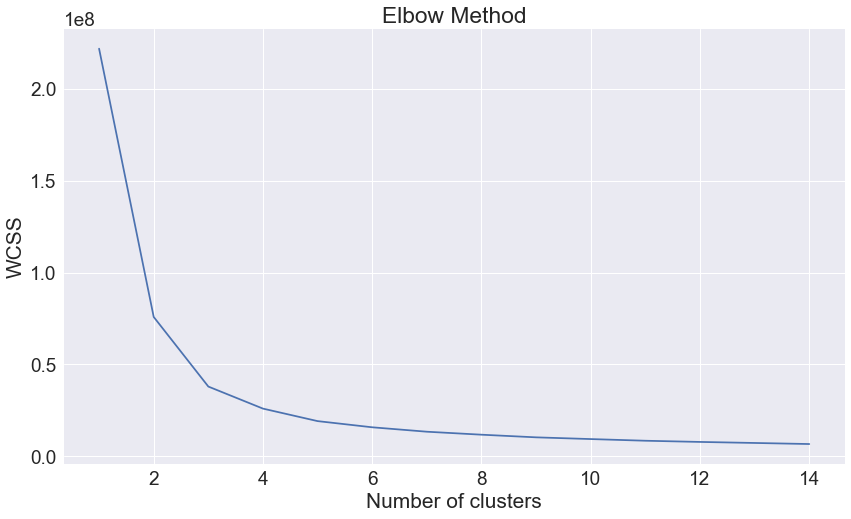

In [24]:
from sklearn.cluster import KMeans
wcss = []
for i in range (1,15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300,n_init = 10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15), wcss)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [25]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300,n_init = 10)
y_kmeans = kmeans.fit_predict(X)

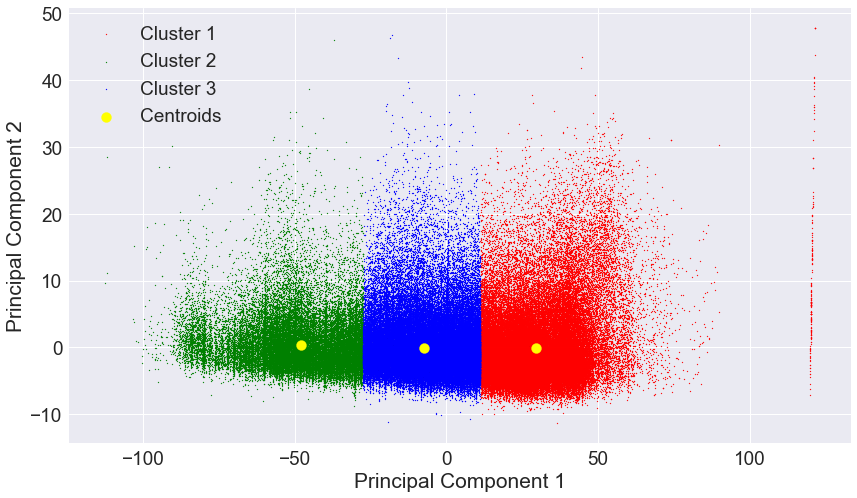

In [26]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 1, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 1, c = 'green', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 1, c = 'blue', label = 'Cluster 3')
#plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 1, c = 'magenta', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=100,c='yellow',label = 'Centroids')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

### <font color='green'>Above , we have plotted 3 clusters of the songs, further scope of the project could be further anlalysing these clusters and see if we find any more intering insights from the data.</font>

# <font color='Orange'> 6 - Thanks :) </font>
link to video - https://youtu.be/jHbWDxOttUk